In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/project/Model 1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, CuDNNLSTM
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# **Data Process**

In [ ]:
# Purpose here: make our data into the form that can be feeded into the neural network

######### PART ONE : Some Auxiliary Function ##############
# a function to transform X and Y into rolling window of length 'T'
def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T : N]
    dataX = np.zeros((N - T, T, D))
    for i in range(T, N):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

# a function that will be used in the next 'normalizaiton_zscore' function
def rolling_window(a, window):
  shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
  strides = a.strides + (a.strides[-1],)
  return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

#  a function that standardize data into z-score by the method of rolling window
def normalization_zscore(arr, window):
  arr=arr.T
  mean = np.mean(rolling_window(arr,window),-1)
  std = np.mean(rolling_window(arr,window),-1)
  arr1=arr[:,(window-1):]
  return ((arr1-mean)/std).T


######### PART TWO: Main Function for Data Preparation ##############

def prepare_x_y(df, stock, k, T, alpha=1e-05, normalization_window=5):

  # 'df' is the input data
  # 'stock' is the number code of the stock (e.g. 'MSFT' is '1')
  # 'k' is prediction horizon
  # 'T' is the length of a single input
  # 'alpha' is threshold of going up or down

  X = (df[df['Stock']==stock].iloc[:, 3:]).copy()
  list_columns=['PRICE_ASK_0','VOLUME_ASK_0','PRICE_BID_0','VOLUME_BID_0',
                'PRICE_ASK_1','VOLUME_ASK_1','PRICE_BID_1','VOLUME_BID_1',
                'PRICE_ASK_2','VOLUME_ASK_2','PRICE_BID_2','VOLUME_BID_2',
                'PRICE_ASK_3','VOLUME_ASK_3','PRICE_BID_3','VOLUME_BID_3',
                'PRICE_ASK_4','VOLUME_ASK_4','PRICE_BID_4','VOLUME_BID_4',
                'PRICE_ASK_5','VOLUME_ASK_5','PRICE_BID_5','VOLUME_BID_5',
                'PRICE_ASK_6','VOLUME_ASK_6','PRICE_BID_6','VOLUME_BID_6',
                'PRICE_ASK_7','VOLUME_ASK_7','PRICE_BID_7','VOLUME_BID_7',
                'PRICE_ASK_8','VOLUME_ASK_8','PRICE_BID_8','VOLUME_BID_8',
                'PRICE_ASK_9','VOLUME_ASK_9','PRICE_BID_9','VOLUME_BID_9']
  # only extract the columns listed above
  X=X[list_columns]
  X=X.reset_index(drop=True)

  # calculate the mid price of stock
  mid=(X['PRICE_ASK_0']+X['PRICE_BID_0'])/2
  
  # Here we smooth our data to label the price movement
  # m_minus is the mean of the previous k mid-price
  m_minus=mid.rolling(window = k).mean()
  for i in range(k-1):
    m_minus[i]=mid[:(i+1)].mean()
  
  # m_plus is the mean of the next k mid-price
  m_plus=m_minus.copy()
  m_plus[:(len(X)-k)]=m_plus[k:]
  for i in range(k):
    m_plus[len(X)-k+i]=mid[(len(X)-k+i):].mean()
  
  # l is the percentage change of smoothed mid-price
  l=(m_plus-m_minus)/m_minus
  Y=l.copy()
  Y[l<=-alpha] = 0  # stock price is going to decrease (red)
  Y[(l>-alpha)&(l<=alpha)] = 1  # stock price is going to be steady (white)
  Y[l>alpha] = 2  # stock price is going to increase (green)
  
  # Conduct the rolling normalize of X after labelling
  X=pd.DataFrame(normalization_zscore(np.array(X), normalization_window),columns=list_columns)

  # transform X and Y into rolling window of length 'T'
  X, Y = data_classification(X, Y, T=T)

  # change Y to the form of one-hot coding
  Y = np_utils.to_categorical(Y, 3)
  
  return mid, X, Y

In [ ]:
TWTR=pd.read_csv('TWTR.csv')
UBER=pd.read_csv('UBER.csv')
TSLA=pd.read_csv('TSLA.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df=pd.concat([TWTR, UBER, TSLA])
X1,Y1 = prepare_x_y(df=df, stock=1, k=10, T=100, alpha=1e-04, normalization_window=10)  #function prepare_x_y is in Dataprocessing2
X2,Y2 = prepare_x_y(df=df, stock=2, k=10, T=100, alpha=1e-04, normalization_window=10)
X3,Y3 = prepare_x_y(df=df, stock=3, k=10, T=100, alpha=1e-04, normalization_window=10)

X = np.concatenate((X1,X2,X3),axis = 0)
Y = np.concatenate((Y1,Y2,Y3),axis = 0)

In [ ]:
X1.shape

(49000, 100, 40, 1)

# **Model 1**

## **Define Model: Adjust Parameter in this Function**
We change optimizer, learning rate, and parameter of L1 regularizers to get idea result. After ajustment, we fix the parameter L1 regularizer as 0.05. Here, we show the training result of optimizer 'Adam' and 'SGD', and learning rate $10^{-4}$ and $10^{-3}$.

In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.3, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy')])

    return model
    
deeplob1 = create_deeplob(100, 40, 64)
deeplob1.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 20, 32)  96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 20, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 20, 32)  4128        ['leaky_re_lu[0][0]']        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## **Prediction Horizon k = 10**
## **Optimizer: Adam**
## **Learning Rate: $10^{-4}$**

In [ ]:
earlystopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=8)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Lei_adam1e-4.h5', #change file name here
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)

history1 = deeplob1.fit(X1, Y1, 
                    shuffle=True,
                    epochs=100,
                    batch_size=128,
                    validation_split=0.25,
                    # steps_per_epoch = 100,
                    callbacks=[earlystopping, model_checkpoint_callback])

Epoch 1/100
288/288 [==============================] - 12s 34ms/step - loss: 101.8629 - accuracy: 0.4759 - top2_accuracy: 0.9456 - val_loss: 78.2588 - val_accuracy: 0.5304 - val_top2_accuracy: 0.9505
Epoch 2/100
288/288 [==============================] - 9s 32ms/step - loss: 59.5600 - accuracy: 0.4838 - top2_accuracy: 0.9492 - val_loss: 42.9273 - val_accuracy: 0.5246 - val_top2_accuracy: 0.9505
Epoch 3/100
288/288 [==============================] - 9s 33ms/step - loss: 31.1302 - accuracy: 0.4874 - top2_accuracy: 0.9492 - val_loss: 21.5606 - val_accuracy: 0.4922 - val_top2_accuracy: 0.9505
Epoch 4/100
288/288 [==============================] - 9s 32ms/step - loss: 16.3259 - accuracy: 0.4841 - top2_accuracy: 0.9492 - val_loss: 12.2812 - val_accuracy: 0.5326 - val_top2_accuracy: 0.9505
Epoch 5/100
288/288 [==============================] - 9s 32ms/step - loss: 9.8641 - accuracy: 0.4868 - top2_accuracy: 0.9492 - val_loss: 7.7691 - val_accuracy: 0.5328 - val_top2_accuracy: 0.9505
Epoch 6/10

In [ ]:
deeplob1.save_weights("deeplob1_adam1e-4_weight")

In [ ]:
deeplob1.load_weights("deeplob1_adam1e-4_weight")

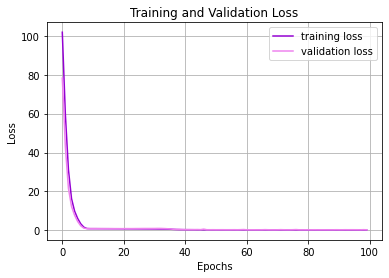

In [ ]:
plt.figure()
plt.plot(history1.history['loss'], label='training loss',color='darkviolet')
plt.plot(history1.history['val_loss'], label='validation loss',color='violet')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)

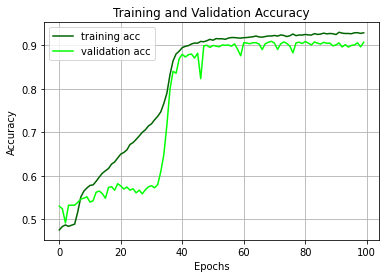

In [ ]:
plt.figure()
plt.plot(history1.history['accuracy'], label='training acc',color='darkgreen')
plt.plot(history1.history['val_accuracy'], label='validation acc',color='lime')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(True)

## **Prediction Horizon k = 10**
## **Optimizer: Adam**
## **Learning Rate: $10^{-3}$**

In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.3, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy')])

    return model
    
deeplob3 = create_deeplob(100, 40, 64)
# deeplob1.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
earlystopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Lei_adam1e-3.h5', #change file name here
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)

history3 = deeplob3.fit(X, Y, 
                    shuffle=True,
                    epochs=100,
                    batch_size=128,
                    validation_split=0.25,
                    callbacks=[earlystopping, model_checkpoint_callback])

Epoch 1/100
1302/1302 [==============================] - 53s 33ms/step - loss: 6.2037 - accuracy: 0.4576 - top2_accuracy: 0.9015 - val_loss: 1.1893 - val_accuracy: 0.4623 - val_top2_accuracy: 0.9305
Epoch 2/100
1302/1302 [==============================] - 40s 31ms/step - loss: 1.1761 - accuracy: 0.4621 - top2_accuracy: 0.9015 - val_loss: 1.1661 - val_accuracy: 0.4700 - val_top2_accuracy: 0.9305
Epoch 3/100
1302/1302 [==============================] - 41s 31ms/step - loss: 1.1802 - accuracy: 0.4592 - top2_accuracy: 0.9015 - val_loss: 1.1647 - val_accuracy: 0.4570 - val_top2_accuracy: 0.9305
Epoch 4/100
1302/1302 [==============================] - 40s 31ms/step - loss: 1.1731 - accuracy: 0.4878 - top2_accuracy: 0.9015 - val_loss: 1.1660 - val_accuracy: 0.4654 - val_top2_accuracy: 0.9305
Epoch 5/100
1302/1302 [==============================] - 41s 31ms/step - loss: 0.9428 - accuracy: 0.6593 - top2_accuracy: 0.9170 - val_loss: 0.5035 - val_accuracy: 0.8987 - val_top2_accuracy: 0.9677
Epoch

In [ ]:
deeplob3.save_weights("deeplob3_adam1e-3_weight")

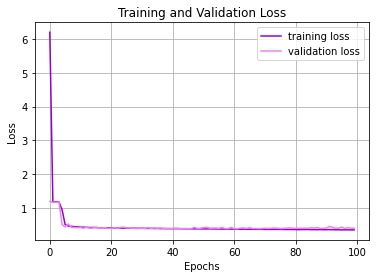

In [ ]:
plt.figure()
plt.plot(history3.history['loss'], label='training loss',color='darkviolet')
plt.plot(history3.history['val_loss'], label='validation loss',color='violet')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)

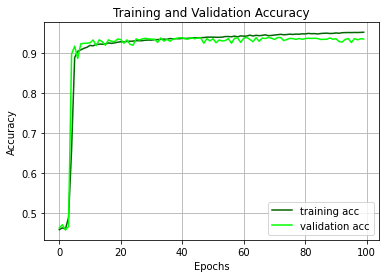

In [ ]:
plt.figure()
plt.plot(history3.history['accuracy'], label='training acc',color='darkgreen')
plt.plot(history3.history['val_accuracy'], label='validation acc',color='lime')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(True)

## **Prediction Horizon k = 10**
## **Optimizer: SGD**
## **Learning Rate: $10^{-4}$**

In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.3, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.SGD(lr = 1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy')])

    return model
    
deeplob_SGD1 = create_deeplob(100, 40, 64)
# deeplob1.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
earlystopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Lei_k=10sgd1e-4.h5', #change file name here
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)

history_SGD1 = deeplob_SGD1.fit(X1, Y1, 
                    shuffle=True,
                    epochs=100,
                    batch_size=128,
                    validation_split=0.25,
                    # steps_per_epoch = 100,
                    callbacks=[earlystopping, model_checkpoint_callback])

Epoch 1/100
288/288 [==============================] - 33s 53ms/step - loss: 26.3513 - accuracy: 0.4798 - top2_accuracy: 0.9492 - val_loss: 26.2876 - val_accuracy: 0.5198 - val_top2_accuracy: 0.9505
Epoch 2/100
288/288 [==============================] - 13s 46ms/step - loss: 26.2256 - accuracy: 0.4880 - top2_accuracy: 0.9492 - val_loss: 26.1622 - val_accuracy: 0.5239 - val_top2_accuracy: 0.9505
Epoch 3/100
288/288 [==============================] - 13s 46ms/step - loss: 26.1011 - accuracy: 0.4884 - top2_accuracy: 0.9492 - val_loss: 26.0381 - val_accuracy: 0.5280 - val_top2_accuracy: 0.9505
Epoch 4/100
288/288 [==============================] - 14s 47ms/step - loss: 25.9777 - accuracy: 0.4871 - top2_accuracy: 0.9492 - val_loss: 25.9153 - val_accuracy: 0.5278 - val_top2_accuracy: 0.9505
Epoch 5/100
288/288 [==============================] - 14s 50ms/step - loss: 25.8554 - accuracy: 0.4869 - top2_accuracy: 0.9492 - val_loss: 25.7933 - val_accuracy: 0.5294 - val_top2_accuracy: 0.9505
Epoch

In [ ]:
pd.DataFrame(history_SGD1.history).to_csv('sgd1e-3.csv')

## **Prediction Horizon k = 10**
## **Optimizer: SGD**
## **Learning Rate: $10^{-3}$**

In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.3, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.SGD(lr = 1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy')])

    return model
    
deeplob_SGD2 = create_deeplob(100, 40, 64)
# deeplob1.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
earlystopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Lei_k=10sgd1e-3.h5', #change file name here
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)

history_SGD2 = deeplob_SGD2.fit(X1, Y1, 
                    shuffle=True,
                    epochs=100,
                    batch_size=128,
                    validation_split=0.25,
                    # steps_per_epoch = 100,
                    callbacks=[earlystopping, model_checkpoint_callback])

Epoch 1/100
288/288 [==============================] - 9s 33ms/step - loss: 16.2939 - accuracy: 0.4887 - top2_accuracy: 0.9492 - val_loss: 15.8672 - val_accuracy: 0.5282 - val_top2_accuracy: 0.9505
Epoch 2/100
288/288 [==============================] - 10s 33ms/step - loss: 15.4671 - accuracy: 0.4891 - top2_accuracy: 0.9492 - val_loss: 15.0547 - val_accuracy: 0.5292 - val_top2_accuracy: 0.9505
Epoch 3/100
288/288 [==============================] - 9s 33ms/step - loss: 14.6689 - accuracy: 0.4875 - top2_accuracy: 0.9492 - val_loss: 14.2709 - val_accuracy: 0.5295 - val_top2_accuracy: 0.9505
Epoch 4/100
288/288 [==============================] - 9s 32ms/step - loss: 13.8986 - accuracy: 0.4875 - top2_accuracy: 0.9492 - val_loss: 13.5145 - val_accuracy: 0.5269 - val_top2_accuracy: 0.9505
Epoch 5/100
288/288 [==============================] - 9s 33ms/step - loss: 13.1556 - accuracy: 0.4870 - top2_accuracy: 0.9492 - val_loss: 12.7847 - val_accuracy: 0.5300 - val_top2_accuracy: 0.9505
Epoch 6/1

In [ ]:
pd.DataFrame(history_SGD2.history).to_csv('sgdtrue1e-3.csv')

## **Prediction Horizon k = 20**
## **Optimizer: Adam**
## **Learning Rate: $10^{-4}$**

In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.3, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy')])

    return model
    
deeplob2_1 = create_deeplob(100, 40, 64)
# deeplob1.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
earlystopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Lei_k=20adam1e-4.h5', #change file name here
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)

history2_1 = deeplob2_1.fit(X, Y, 
                    shuffle=True,
                    epochs=100,
                    batch_size=128,
                    validation_split=0.25,
                    callbacks=[earlystopping, model_checkpoint_callback])

Epoch 1/100
1302/1302 [==============================] - 53s 33ms/step - loss: 47.2145 - accuracy: 0.4735 - top2_accuracy: 0.9314 - val_loss: 9.4885 - val_accuracy: 0.4702 - val_top2_accuracy: 0.9531
Epoch 2/100
1302/1302 [==============================] - 40s 31ms/step - loss: 3.5511 - accuracy: 0.4818 - top2_accuracy: 0.9316 - val_loss: 0.8869 - val_accuracy: 0.4700 - val_top2_accuracy: 0.9531
Epoch 3/100
1302/1302 [==============================] - 40s 31ms/step - loss: 0.9117 - accuracy: 0.4816 - top2_accuracy: 0.9316 - val_loss: 0.8981 - val_accuracy: 0.4686 - val_top2_accuracy: 0.9531
Epoch 4/100
1302/1302 [==============================] - 40s 31ms/step - loss: 0.9098 - accuracy: 0.4817 - top2_accuracy: 0.9316 - val_loss: 0.8876 - val_accuracy: 0.4684 - val_top2_accuracy: 0.9531
Epoch 5/100
1302/1302 [==============================] - 40s 31ms/step - loss: 0.9087 - accuracy: 0.4842 - top2_accuracy: 0.9316 - val_loss: 0.8881 - val_accuracy: 0.4687 - val_top2_accuracy: 0.9531
Epoc

In [ ]:
deeplob2_1.save_weights("deeplob_k20adam1e-4_weight.h5")

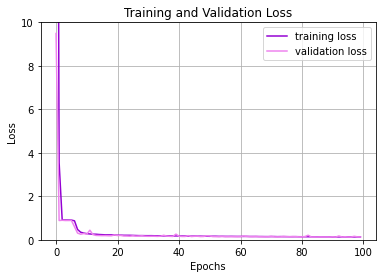

In [ ]:
plt.figure()
plt.plot(history2_1.history['loss'], label='training loss',color='darkviolet')
plt.plot(history2_1.history['val_loss'], label='validation loss',color='violet')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0,10))
plt.title('Training and Validation Loss')
plt.grid(True)

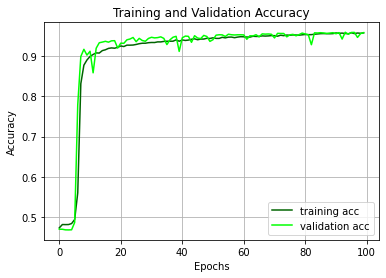

In [ ]:
plt.figure()
plt.plot(history2_1.history['accuracy'], label='training acc',color='darkgreen')
plt.plot(history2_1.history['val_accuracy'], label='validation acc',color='lime')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(True)

## **Prediction Horizon k = 50**
## **Optimizer: Adam**
## **Learning Rate: $10^{-4}$**

In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', kernel_regularizer =tf.keras.regularizers.l1( l=0.05))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.3, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy')])

    return model
    
deeplob3_1 = create_deeplob(100, 40, 64)
# deeplob1.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
earlystopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Lei_k=50adam1e-4.h5', #change file name here
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)

history3_1 = deeplob3_1.fit(X, Y, 
                    shuffle=True,
                    epochs=100,
                    batch_size=128,
                    validation_split=0.25,
                    callbacks=[earlystopping, model_checkpoint_callback])

In [ ]:
deeplob3_1.save_weights("deeplob_k50adam1e-4_weight.h5")

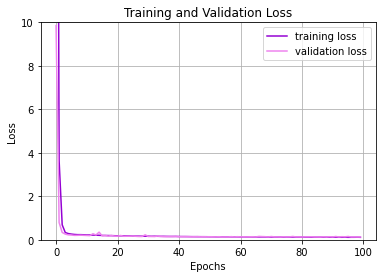

In [ ]:
plt.figure()
plt.plot(history3_1.history['loss'], label='training loss',color='darkviolet')
plt.plot(history3_1.history['val_loss'], label='validation loss',color='violet')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0,10))
plt.title('Training and Validation Loss')
plt.grid(True)

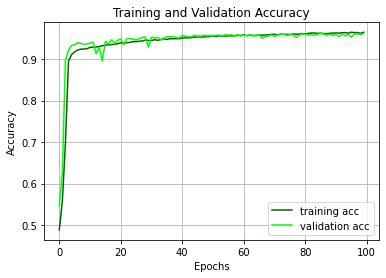

In [ ]:
plt.figure()
plt.plot(history3_1.history['accuracy'], label='training acc',color='darkgreen')
plt.plot(history3_1.history['val_accuracy'], label='validation acc',color='lime')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(True)

In [ ]:
pd.DataFrame(history3_1.history).to_csv('Lei_k=50_plot_acc.csv')
# to_csv('Lei_k=50_plot_acc.csv')

## **Visulization**

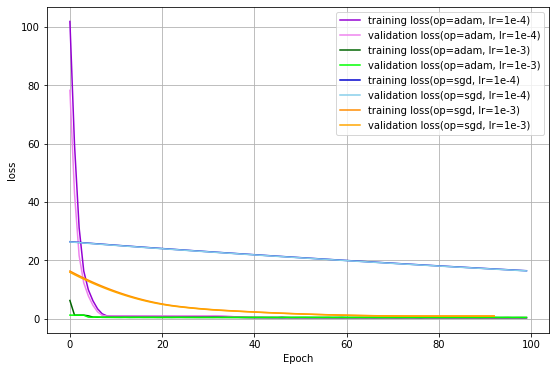

In [ ]:
plot1val = np.load('Lei_adam1e-4plot_valloss.npy')
plot2val = np.load('Lei_adam1e-3plot_valloss.npy')
plot1 = np.load('Lei_adam1e-4plot_loss.npy')
plot2 = np.load('Lei_adam1e-3plot_loss.npy')

plot3val = pd.read_csv('sgd1e-4.csv')['val_loss']
plot4val = pd.read_csv('sgdtrue1e-3.csv')['val_loss']
plot3 = pd.read_csv('sgd1e-4.csv')['loss']
plot4 = pd.read_csv('sgdtrue1e-3.csv')['loss']

fig = plt.figure(figsize=(9, 6))
ax1 = fig.subplots(nrows=1, ncols=1)
ax1.plot(plot1, color = 'darkviolet', label = 'training loss(op=adam, lr=1e-4)')
ax1.plot(plot1val, color = 'violet', label = 'validation loss(op=adam, lr=1e-4)')
ax1.plot(plot2, color = 'darkgreen', label = 'training loss(op=adam, lr=1e-3)')
ax1.plot(plot2val, color = 'lime', label = 'validation loss(op=adam, lr=1e-3)')
ax1.plot(plot3, color = 'mediumblue', label = 'training loss(op=sgd, lr=1e-4)')
ax1.plot(plot3val, color = 'skyblue', label = 'validation loss(op=sgd, lr=1e-4)')
ax1.plot(plot4, color = 'darkorange', label = 'training loss(op=sgd, lr=1e-3)')
ax1.plot(plot4val, color = 'orange', label = 'validation loss(op=sgd, lr=1e-3)')


ax1.legend(fontsize = 10)
ax1.set_xlabel('Epoch',fontsize = 10)
ax1.set_ylabel('loss',fontsize = 10)
ax1.grid(True)

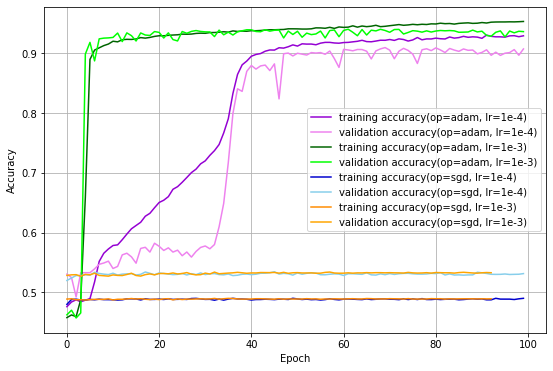

In [ ]:
plot1val = np.load('Lei_k=10adam1e-4plot.npy')
plot2val = np.load('Lei_k=10adam1e-3plot.npy')
plot1 = np.load('Lei_adam1e-4plot_acc.npy')
plot2 = np.load('Lei_adam1e-3plot_acc.npy')

plot3val = pd.read_csv('sgd1e-4.csv')['val_accuracy'] 
plot4val = pd.read_csv('sgdtrue1e-3.csv')['val_accuracy']
plot3 = pd.read_csv('sgd1e-4.csv')['accuracy']
plot4 = pd.read_csv('sgdtrue1e-3.csv')['accuracy']

fig = plt.figure(figsize=(9, 6))
ax1 = fig.subplots(nrows=1, ncols=1)
ax1.plot(plot1, color = 'darkviolet', label = 'training accuracy(op=adam, lr=1e-4)')
ax1.plot(plot1val, color = 'violet', label = 'validation accuracy(op=adam, lr=1e-4)')
ax1.plot(plot2, color = 'darkgreen', label = 'training accuracy(op=adam, lr=1e-3)')
ax1.plot(plot2val, color = 'lime', label = 'validation accuracy(op=adam, lr=1e-3)')
ax1.plot(plot3, color = 'mediumblue', label = 'training accuracy(op=sgd, lr=1e-4)')
ax1.plot(plot3val, color = 'skyblue', label = 'validation accuracy(op=sgd, lr=1e-4)')
ax1.plot(plot4, color = 'darkorange', label = 'training accuracy(op=sgd, lr=1e-3)')
ax1.plot(plot4val, color = 'orange', label = 'validation accuracy(op=sgd, lr=1e-3)')


ax1.legend(fontsize = 10)
ax1.set_xlabel('Epoch',fontsize = 10)
ax1.set_ylabel('Accuracy',fontsize = 10)
ax1.grid(True)

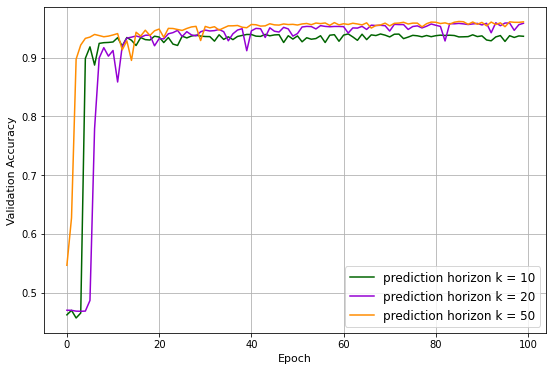

In [ ]:
plot1 = np.load('Lei_k=10adam1e-4plot.npy')
plot2 = np.load('Lei_k=10adam1e-3plot.npy')
plot3 = np.load('Lei_k=20adam1e-4plot.npy')
plot4 = pd.read_csv('Lei_k=50_plot_acc.csv')
plot4 = plot4['val_accuracy']


fig = plt.figure(figsize=(9, 6))
ax1 = fig.subplots(nrows=1, ncols=1)
# ax1.plot(plot1, color = 'darkviolet', label = 'k = 10-1')
ax1.plot(plot2, color = 'darkgreen', label = 'prediction horizon k = 10')
ax1.plot(plot3, color = 'darkviolet', label = 'prediction horizon k = 20')
ax1.plot(plot4, color = 'darkorange', label = 'prediction horizon k = 50')
ax1.legend(fontsize = 12)
ax1.set_xlabel('Epoch',fontsize = 11)
ax1.set_ylabel('Validation Accuracy',fontsize = 11)
# ax1.set_title('Mid Price of BILI from 2021-11-1 to 2021-11-12',fontsize = 23)
ax1.grid(True)

# **Model 2**

## **Define Model: Adjust Parameter in this Function**
Here, we show the training result of optimizer 'Adam' and 'SGD', and learning rate $10^{-4}$ and $10^{-2}$.

In [ ]:
def create_deeplob2(T, NF):
    input_lmd = Input(shape=(T, NF,1))
    
    # build the convolutional block
    conv_first1 = Conv2D(16, (4, 40))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4,1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = MaxPooling2D((2,1), padding='same')(conv_first1)

    conv_first1 = Conv2D(32, (3,1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (3,1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = MaxPooling2D((2,1), padding='same')(conv_first1)

    conv = Flatten()(conv_first1)
    conv = Dropout(0.2)(conv)
    conv = Dense(32)(conv)
    out = Dense(3, activation = 'softmax')(conv)

    model = Model(inputs=input_lmd, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy')])

    return model
    
deeplob2 = create_deeplob2(100, 40)
deeplob2.summary()

## Training Results of the Model is omitted here but have been saved in csv files. And we conduct the visualization of training result as followed.

## **Visualization**

In [ ]:
adam2 = pd.read_csv('cy1_adam-2.csv')
adam4 = pd.read_csv('cy1_adam-4.csv')
sgd2 = pd.read_csv('cy1_sgd-2.csv')
sgd4 = pd.read_csv('cy1_sgd-4.csv')
adam4_2 = pd.read_csv('cy2_adam-4.csv')
adam4_5 = pd.read_csv('cy5_adam-4.csv')

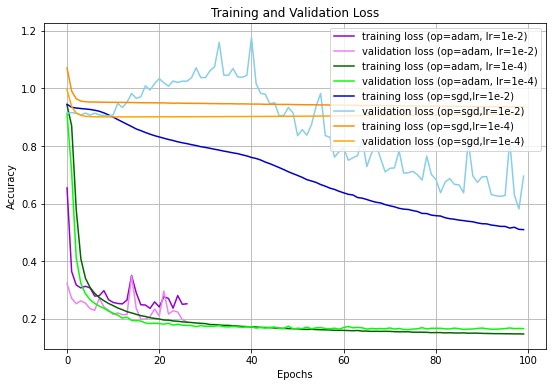

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(9,6))
ax.plot(adam2['loss'], label='training loss (op=adam, lr=1e-2)',color='darkviolet')
ax.plot(adam2['val_loss'], label='validation loss (op=adam, lr=1e-2)',color='violet')
ax.plot(adam4['loss'], label='training loss (op=adam, lr=1e-4)',color='darkgreen')
ax.plot(adam4['val_loss'], label='validation loss (op=adam, lr=1e-4)',color='lime')
ax.plot(sgd2['loss'], label='training loss (op=sgd,lr=1e-2)',color='mediumblue')
ax.plot(sgd2['val_loss'], label='validation loss (op=sgd,lr=1e-2)',color='skyblue')
ax.plot(sgd4['loss'], label='training loss (op=sgd,lr=1e-4)',color='darkorange')
ax.plot(sgd4['val_loss'], label='validation loss (op=sgd,lr=1e-4)',color='orange')
ax.set_title('Training and Validation Loss')
ax.legend(loc='upper right')
ax.set(xlabel='Epochs', ylabel='Accuracy')
ax.grid(True)

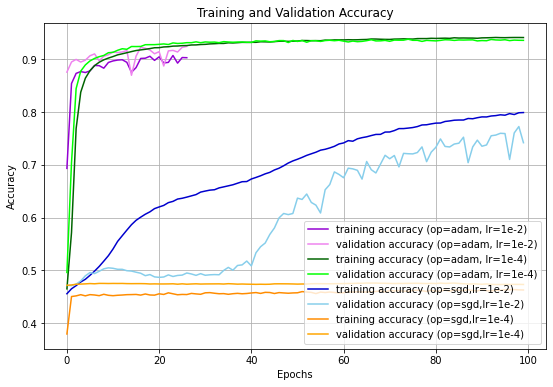

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(9,6))
ax.plot(adam2['accuracy'], label='training accuracy (op=adam, lr=1e-2)',color='darkviolet')
ax.plot(adam2['val_accuracy'], label='validation accuracy (op=adam, lr=1e-2)',color='violet')
ax.plot(adam4['accuracy'], label='training accuracy (op=adam, lr=1e-4)',color='darkgreen')
ax.plot(adam4['val_accuracy'], label='validation accuracy (op=adam, lr=1e-4)',color='lime')
ax.plot(sgd2['accuracy'], label='training accuracy (op=sgd,lr=1e-2)',color='mediumblue')
ax.plot(sgd2['val_accuracy'], label='validation accuracy (op=sgd,lr=1e-2)',color='skyblue')
ax.plot(sgd4['accuracy'], label='training accuracy (op=sgd,lr=1e-4)',color='darkorange')
ax.plot(sgd4['val_accuracy'], label='validation accuracy (op=sgd,lr=1e-4)',color='orange')
ax.set_title('Training and Validation Accuracy')
ax.legend(loc='lower right')
ax.set(xlabel='Epochs', ylabel='Accuracy')
ax.grid(True)

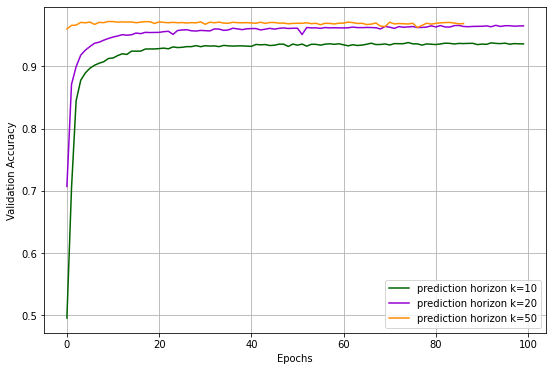

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(9,6))

ax.plot(adam4['val_accuracy'], label='prediction horizon k=10',color='darkgreen')
ax.plot(adam4_2['val_accuracy'], label='prediction horizon k=20',color='darkviolet')
ax.plot(adam4_5['val_accuracy'], label='prediction horizon k=50',color='darkorange')

ax.legend(loc='lower right')
ax.set(xlabel='Epochs', ylabel='Validation Accuracy')
ax.grid(True)